In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [2]:
def iterate(iterations):
    for i in range(0, iterations):
        for sublattice in [False, True]:
            neighbors = np.roll(lattice, 1, 0) \
                       + np.roll(lattice, -1, 0) \
                       + np.roll(lattice, 1, 1) \
                       + np.roll(lattice, -1, 1)
            energy = 2 * lattice * neighbors
            boltzman = np.exp(- beta * energy)
            randoms = np.random.random(size)
            flip = (randoms < boltzman) | (boltzman >= 1)
            flip[mask == sublattice] = False
            lattice[flip] *= -1

In [71]:
X_SIZE=128
Y_SIZE=128

ITERATIONS = 10000
MEASURE_INTERVAL = 100
MEASUREMENTS = ITERATIONS/MEASURE_INTERVAL
THERMALIZE_ITERATIONS = 10000

magnetization = np.zeros((ITERATIONS / MEASURE_INTERVAL), dtype = float)

betas = [0.43, 0.438, 0.4385, 0.439, \
         0.4395, 0.44, 0.4405, 0.441, \
         0.4415, 0.442, 0.45, 0.46]

betaC = 0.4407

correlation = np.zeros((len(betas), X_SIZE / 2), dtype = float)

size = (X_SIZE, Y_SIZE)

lattice = np.random.randint(low = 0, high = 2, size=size) * 2 - 1

mask = np.ones_like(lattice)

mask[::2, ::2] = 0
mask[1::2, 1::2] = 0

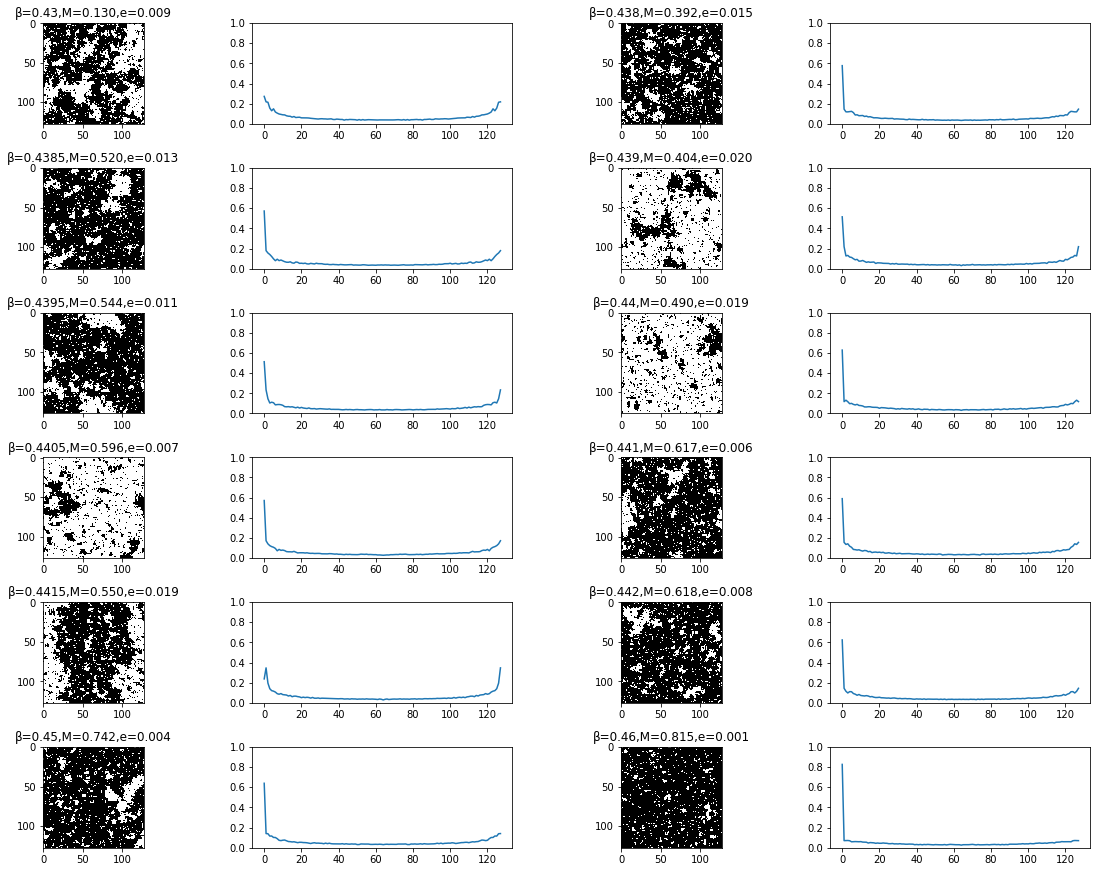

In [72]:
fig = plt.figure(figsize=(16, 16))

# Simulate one β at a time
for betaId in range(0, len(betas)):
    beta = betas[betaId]
    iterate(THERMALIZE_ITERATIONS)
    for j in range(0, MEASUREMENTS):
        iterate(MEASURE_INTERVAL)
        # Measure magnetization
        magnetization[j] = np.abs(np.mean(lattice))

    # Plot the final state
    x, y = betaId / 2, betaId % 2
    plt.subplot2grid(shape = (8, 4), loc=(x, y * 2))
    plt.imshow(lattice, cmap='binary')
    plt.title(u"β=" + str(beta) + ",M=" + str(np.mean(magnetization))[0:5] \
              + ",e=" + str(np.std(magnetization) / np.sqrt(MEASUREMENTS))[0:5])
    
    # Do an FFT to figure out the correlation function
    inv = np.fft.fft(lattice)
    # Don't care about the phase just amplitude
    length = np.sqrt(inv.real ** 2 + inv.imag ** 2)
    #print "Len", length
    # Since the FFT was run over the last dimension find average of frequency spectrum along the first
    tmp = np.mean(length, axis=0) / 128
    correlation[betaId] = tmp[0:X_SIZE / 2]
    plt.subplot2grid(shape = (8, 4), loc=(x, y * 2 + 1))
    plt.ylim(0.0, 1.0)
    plt.plot(tmp)
plt.tight_layout()
plt.show()

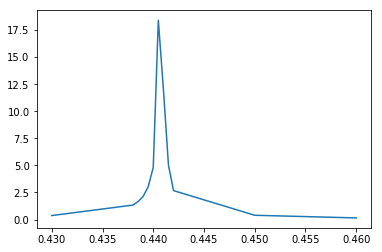

In [98]:
# Estimate correlation function
fits = np.zeros((len(betas), 2), dtype = float)

for betaId in range(0, len(betas)):
    log = np.log(correlation[betaId, 1: X_SIZE / 2])
    x = np.arange(1, X_SIZE / 2) * np.abs(1/betas[betaId] - 1/betaC)
    fit = np.polyfit(x, log, 1)
    fits[betaId] = (betas[betaId], np.abs(fit[0]))

plt.plot(fits[:,0], fits[:,1])